# FairVIC Supplementary Code
In this notebook you can find all of the supplementary code behind our method, FairVIC.

## Misc (Imports, Misc. functions, preprocessing)
This section is full of various imports, generic functions, or preprocessing steps for the data that is used. It is unimportant but skim through if you would like.

### Imports

In [1]:
!pip install ucimlrepo
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 14.6 MB/s eta 0:00:00


In [2]:
# initialisations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)}
)

# fairness metrics
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score
from tensorflow.keras.losses import binary_crossentropy

# save results
import pickle

# suppress warnings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Import the dataset

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

In [4]:
# check to see if the data has imported correctly
X.head(4)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States


In [5]:
# sort the target variables to be correct
y['income'] = y['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'})

### Preprocessing data

In [6]:
# feature selection
X = X[['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']]
X.dtypes

,0
age,int64
workclass,object
education,object
marital-status,object
occupation,object
relationship,object
race,object
sex,object
capital-gain,int64
capital-loss,int64


In [7]:
X['workclass'] = X['workclass'].astype('category').cat.codes
X['education'] = X['education'].astype('category').cat.codes
X['marital-status'] = X['marital-status'].astype('category').cat.codes
X['occupation'] = X['occupation'].astype('category').cat.codes
X['relationship'] = X['relationship'].astype('category').cat.codes
X['race'] = X['race'].astype('category').cat.codes
X['sex'] = X['sex'].astype('category').cat.codes
X['native-country'] = X['native-country'].astype('category').cat.codes
y['income'] = y['income'].astype('category').cat.codes

In [8]:
X = X.astype('float32')
y = y.astype('float32')

In [9]:
y = y['income']

## FairVIC
Here you will find the code behind our method, FairVIC, please read throught the comments for explanations 😀

### FairVIC class
Here is all the code, in one class, for training a custom neural network on our new loss function FairVIC.

In [10]:
"""
Our fairness loss function, FairVIC
Returns:
  trained model -> a trained model that aims to be as fair as possible
"""
class FairModel():
  def __init__(self):
    self.model = self.create_model()
    self.protected_attribute = None
    self.privileged_groups = None
    self.unprivileged_groups = None
    self.favorable_label = None
    self.unfavorable_label = None

  def configure_fairness_evaluation(self, protected_attribute, privileged_groups, unprivileged_groups, favorable_label, unfavorable_label):
    self.protected_attribute = protected_attribute
    self.privileged_groups = privileged_groups
    self.unprivileged_groups = unprivileged_groups
    self.favorable_label = favorable_label
    self.unfavorable_label = unfavorable_label

  def fairvic_wrapper(self, protected_attribute, lambda_binary, lambda_cov, lambda_var, lambda_inv, eps=1e-4):
      def fairvic_loss(y_true, y_pred):
        y_pred_squeezed = tf.squeeze(y_pred, axis=1)

        binary_loss = binary_crossentropy(y_true, y_pred_squeezed)

        protected = tf.reshape(protected_attribute, (-1, 1))

        variance_loss = tf.reduce_mean(tf.maximum(0., 1. - tf.math.sqrt(tf.reduce_mean(tf.square(protected - tf.reduce_mean(protected, axis=0)), axis=0) + eps)))

        invariance_loss = tf.reduce_mean(tf.square(protected - tf.reduce_mean(protected, axis=0)))

        y_pred_reshaped = tf.reshape(y_pred, (-1, 1))
        cov_matrix = tf.matmul(tf.transpose(y_pred_reshaped - tf.reduce_mean(y_pred_reshaped, axis=0)), protected)
        covariance_loss = tf.sqrt(tf.reduce_sum(tf.square(cov_matrix))) / tf.cast(tf.shape(y_pred_reshaped)[0], tf.float32)

        total_loss = (lambda_binary * binary_loss +
                      lambda_var * variance_loss +
                      lambda_inv * invariance_loss +
                      lambda_cov * covariance_loss)

        return total_loss
      return fairvic_loss

  def create_model(self):
    model = Sequential([
        Dense(256, input_shape=(X_train.shape[1],), kernel_regularizer=L2(1e-4), kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.25),

        Dense(128, kernel_regularizer=L2(1e-4), kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.25),

        Dense(64, kernel_regularizer=L2(1e-4), kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.25),

        Dense(32, kernel_regularizer=L2(1e-4), kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        Dense(1, activation='sigmoid')
    ])
    return model

  @tf.function
  def train_step(self, inputs, labels, protected, optimizer, lambda_binary, lambda_cov, lambda_var, lambda_inv):
      with tf.GradientTape() as tape:
          predictions = self.model(inputs, training=True)
          loss = self.fairvic_wrapper(protected, lambda_binary, lambda_cov, lambda_var, lambda_inv)(labels, predictions)
      gradients = tape.gradient(loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
      return loss

  @tf.function
  def val_step(self, inputs, labels, protected, lambda_binary, lambda_cov, lambda_var, lambda_inv):
      predictions = self.model(inputs, training=False)
      loss = self.fairvic_wrapper(protected, lambda_binary, lambda_cov, lambda_var, lambda_inv)(labels, predictions)
      return loss


  def train(self, epochs, batch_size, X_train, y_train, X_train_protected, X_val, y_val, X_val_protected, lambda_binary, lambda_cov, lambda_var, lambda_inv):
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, X_train_protected)).batch(batch_size)
      val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val, X_val_protected)).batch(batch_size)

      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
      best_val_loss = np.inf
      epoch_train_losses = []
      epoch_val_losses = []

      for epoch in range(epochs):
          print(f"Epoch {epoch+1}/{epochs}")
          train_losses_batch = []
          for batch, (inputs, labels, protected) in enumerate(train_dataset):
              loss = self.train_step(inputs, labels, protected, optimizer, lambda_binary, lambda_cov, lambda_var, lambda_inv)
              train_losses_batch.append(loss.numpy())
          train_loss = np.mean(train_losses_batch)

          val_losses_batch = []
          for batch, (inputs, labels, protected) in enumerate(val_dataset):
              loss = self.val_step(inputs, labels, protected, lambda_binary, lambda_cov, lambda_var, lambda_inv)
              val_losses_batch.append(loss.numpy())
          val_loss = np.mean(val_losses_batch)

          print(f"Epoch {epoch+1}, Loss: {train_loss}, Val Loss: {val_loss}, Lr: {optimizer.learning_rate.numpy()}")
          epoch_train_losses.append(train_loss)
          epoch_val_losses.append(val_loss)

      self.plot_losses(epoch_train_losses, epoch_val_losses)

  # plot the loss history for sanity checks
  def plot_losses(self, train_losses, val_losses):
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.show()

  # evaluate the trained model for accuracy metrics
  def evaluate(self, X_test, y_test):
    predictions = self.model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)

    acc = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    return {'acc': acc, 'auc': auc, 'precision': precision, 'recall': recall, 'f1': f1, 'y_test': y_test, 'y_pred': predictions}

### Using FairVIC
Please follow the walkthrough below on how to use FairVIC

Firstly, we want to split out data in training, validation, and test datasets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

Next, we want to extract the pritected characteristic column from the dataset. In this psuedo-example, we extract only the 'sex' column

In [12]:
protected_attribute_column_name = 'sex'
X_train_protected = X.loc[X_train.index, protected_attribute_column_name]
X_test_protected = X.loc[X_test.index, protected_attribute_column_name]
X_val_protected = X.loc[X_val.index, protected_attribute_column_name]

We then can do some standard scaling of the data which is typical for most neural net training

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

Next, we need to define the model. Here we can just call a new instance of the class and it will instantiate a new neural network that has been created using the 'create_model()' function

In [14]:
fair_model = FairModel()

Now we have everything we need to train the model. In the class you can change the weights of the loss function multiplers by tweaking the

```
lambda_binary=0.1, lambda_cov=0.1, lambda_var=0.1, lambda_inv=0.7
```
variables. 'lambda_binary' in this case is simply our accuracy loss that is used for this example, this can be replaced by any other accuracy loss function. We will use 200 training epochs and a batch size of 256 right now.


In [15]:
lambda_binary = 0.1
lambda_var = 0.1
lambda_inv = 0.1
lambda_cov = 0.7

Epoch 1/200
Epoch 1, Loss: 0.12864507734775543, Val Loss: 0.12514613568782806, Lr: 0.009999999776482582
Epoch 2/200
Epoch 2, Loss: 0.12065405398607254, Val Loss: 0.12345916777849197, Lr: 0.009999999776482582
Epoch 3/200
Epoch 3, Loss: 0.11989383399486542, Val Loss: 0.12143588811159134, Lr: 0.009999999776482582
Epoch 4/200
Epoch 4, Loss: 0.11899888515472412, Val Loss: 0.12544786930084229, Lr: 0.009999999776482582
Epoch 5/200
Epoch 5, Loss: 0.1186145767569542, Val Loss: 0.12246137857437134, Lr: 0.009999999776482582
Epoch 6/200
Epoch 6, Loss: 0.1178520992398262, Val Loss: 0.12161307036876678, Lr: 0.009999999776482582
Epoch 7/200
Epoch 7, Loss: 0.11743129044771194, Val Loss: 0.12204545736312866, Lr: 0.009999999776482582
Epoch 8/200
Epoch 8, Loss: 0.11706726998090744, Val Loss: 0.12010306864976883, Lr: 0.009999999776482582
Epoch 9/200
Epoch 9, Loss: 0.11680823564529419, Val Loss: 0.11904869228601456, Lr: 0.009999999776482582
Epoch 10/200
Epoch 10, Loss: 0.11689164489507675, Val Loss: 0.1179

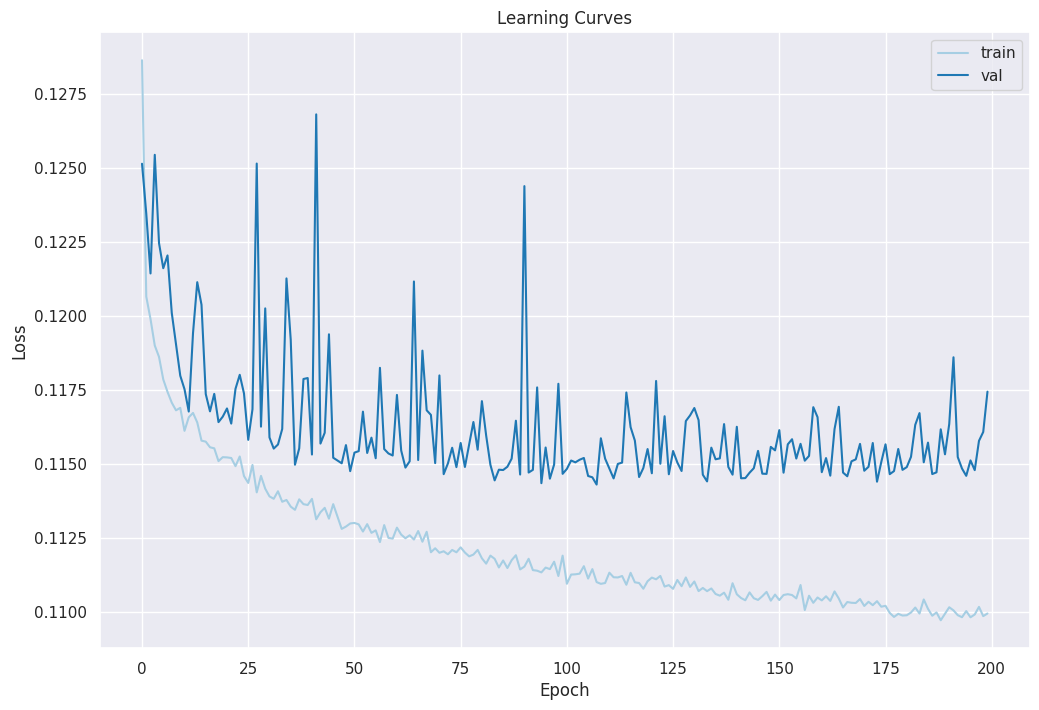

In [16]:
fair_model.train(200, 256,
                 X_train, y_train, X_train_protected, X_val, y_val, X_val_protected,
                 lambda_binary=lambda_binary, lambda_cov=lambda_cov,
                 lambda_var=lambda_var, lambda_inv=lambda_inv)

To evaluate the model's performance in standard accuracy metrics, we have provided a function below to do so. This can obviously be changed to allow for any custom metrics needed.

In [17]:
eval_metrics = fair_model.evaluate(X_test, y_test)

306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


To evaluate the model's performance in fairness metrics, we use this little code snippet below. All that is needed is to specifiy the 'protected attribute' as well as the 'priviledged' and 'unprivileged' groups.

In [18]:
X_test = pd.DataFrame(data=X_test, columns=['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'])
predictions = eval_metrics['y_pred']

test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_df.columns = list(X_test.columns) + ['label']

test_df = test_df.astype(int)

test_bld = BinaryLabelDataset(df=test_df,
                              label_names=['label'],
                              protected_attribute_names=['sex'],
                              favorable_label=1,
                              unfavorable_label=0)

predictions_bld = test_bld.copy()
predictions_bld.labels = predictions.reshape(-1, 1)

classification_metric = ClassificationMetric(test_bld,
                                              predictions_bld,
                                              unprivileged_groups=[{'sex': 0}],
                                              privileged_groups=[{'sex': 1}])

fairness_metrics = {
        'equalized_odds_difference': classification_metric.equalized_odds_difference(),
        'average_abs_odds_difference': classification_metric.average_abs_odds_difference(),
        'disparate_impact': classification_metric.disparate_impact(),
        'demographic_parity_difference': classification_metric.mean_difference(),
    }

Finally, to see our results for both accuracy and fairness, we print every metric here!

In [19]:
print(f"Results")
print("============================================================================================")
print(f"Accuracy: {eval_metrics['acc']}")
print(f"AUC: {eval_metrics['auc']}")
print(f"Precision: {eval_metrics['precision']}")
print(f"Recall: {eval_metrics['recall']}")
print(f"F1 Score: {eval_metrics['f1']}")
print("---------------------------------------------")
print("Fairness Metrics:")
print(f"Equalized Odds Difference: {fairness_metrics['equalized_odds_difference']}")
print(f"Average Absolute Odds Difference: {fairness_metrics['average_abs_odds_difference']}")
print(f"Disparate Impact: {fairness_metrics['disparate_impact']}")
print(f"Demographic Parity (Mean) Difference: {fairness_metrics['demographic_parity_difference']}")
print("============================================================================================")

Results
Accuracy: 0.8384686252431159
AUC: 0.7291715321881167
Precision: 0.7146254458977408
Recall: 0.5226086956521739
F1 Score: 0.6037167252636866
---------------------------------------------
Fairness Metrics:
Equalized Odds Difference: 0.20265809144245073
Average Absolute Odds Difference: 0.11226477857516098
Disparate Impact: 0.7852931559349786
Demographic Parity (Mean) Difference: -0.039833987236081725


That is how you can incorporate FairVIC into a neural network's training. It is elegant yet efficient. We encourage you to mess around with the weights! 😀